In [1]:
#dependencies for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import importlib

sys.path.append(os.path.abspath(".."))
import misc
importlib.reload(misc)
from misc import load_csv_dataset

data = load_csv_dataset("names.csv")
df = pd.DataFrame(data)

>> Loading CSV dataset from names.csv
>> Detected fieldnames: ['name', 'sex', 'region', 'year']
>> Successfully loaded with UTF-8 encoding


In [2]:
#breakdown of names into surname, middle name and first name
#constraint: take into account compound names (eg. ILUNGA WA ILUNGA MARC)
#            take into account missing names (eg. LOKUA KANZA, KASONGO GERMAINE)

df['split'] = df['name'].str.strip().str.split()
df = df[df['split'].notna() & df['split'].str.len() > 0]
df['surname'] = df['split'].apply(lambda x: x[0] if len(x) >= 1 else "null")
df['first_name'] = df['split'].apply(lambda x: x[-1] if len(x) >= 2 else "null")
df['middle_name'] = df['split'].apply(lambda x: ' '.join(x[1:-1]) if len(x) > 2 else "null")
df.drop(columns=['split'], inplace=True)
df[['name', 'surname', 'middle_name', 'first_name']].head()

,name,surname,middle_name,first_name
0,DIKOKO PAMITSHEFU FABRICE,DIKOKO,PAMITSHEFU,FABRICE
1,EPENGE DJONGESONGO JONAS,EPENGE,DJONGESONGO,JONAS
2,EYONGOYONGO SHAKO MICHEL,EYONGOYONGO,SHAKO,MICHEL
3,KASSONGO OSANGO ISRAEL,KASSONGO,OSANGO,ISRAEL
4,OKAWONGA ONGONDJO ALPHONSE,OKAWONGA,ONGONDJO,ALPHONSE


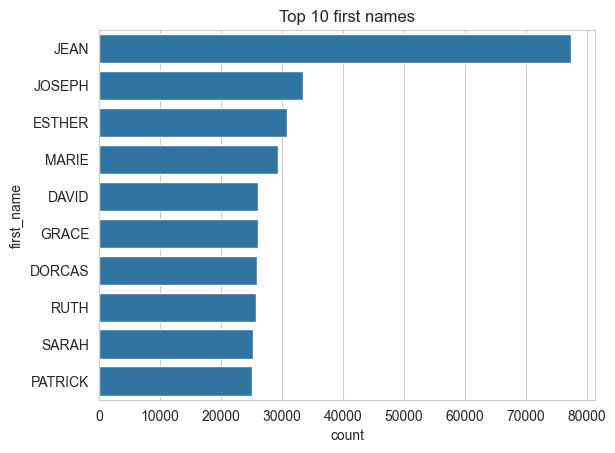

In [3]:
# Simple distribution of first names (display of the 10 most popular first names)
sns.countplot(y=df['first_name'], order=df['first_name'].value_counts().iloc[:10].index)
plt.title("Top 10 first names")
plt.show()

In [4]:
firstnames = df['first_name'].value_counts()
df_firstnames = firstnames.reset_index()
df_firstnames.columns = ['FIrst name', 'quantity']
df_firstnames.head(10)

,FIrst name,quantity
0,JEAN,77520
1,JOSEPH,33433
2,ESTHER,30778
3,MARIE,29289
4,DAVID,26122
5,GRACE,26120
6,DORCAS,25999
7,RUTH,25734
8,SARAH,25275
9,PATRICK,25146


In [5]:
# Total number of distinct first names
total_firstnames = df['first_name'].notna().sum()
print(f">> Total number of first names registered : {total_firstnames}")

# categorization of first names
firstnames_by_sex = df.groupby(['first_name', 'sex']).size().unstack(fill_value=0)
male_firstnames = firstnames_by_sex[(firstnames_by_sex['M'] > 0) & (firstnames_by_sex['F'] == 0)]
print(f">> Number of all-male first names : {len(male_firstnames)}")
female_firstnames = firstnames_by_sex[(firstnames_by_sex['F'] > 0) & (firstnames_by_sex['M'] == 0)]
print(f">> Number of all-female first names : {len(female_firstnames)}")
neutral_firstnames = firstnames_by_sex[(firstnames_by_sex['M'] > 0) & (firstnames_by_sex['F'] > 0)]
print(f">> Number of all-neutral first names : {len(neutral_firstnames)}")


>> Total number of first names registered : 4259140
>> Number of all-male first names : 128856
>> Number of all-female first names : 70806
>> Number of all-neutral first names : 31849


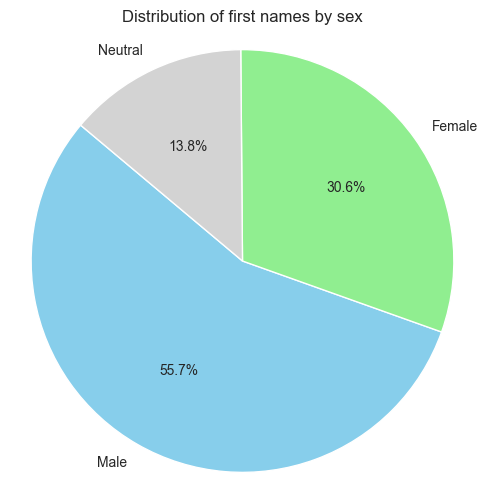

In [6]:
# data for graphic interpretation 
labels = ['Male', 'Female', 'Neutral']
values = [len(male_firstnames), len(female_firstnames), len(neutral_firstnames)]

# circular
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.axis('equal')
plt.show()

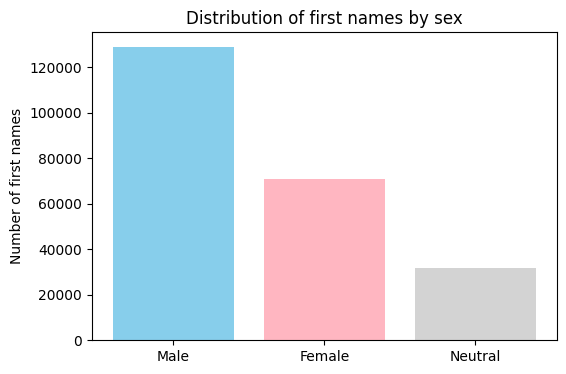

In [7]:
# Histogram
plt.figure(figsize=(6,4))
plt.bar(labels, values, color=['skyblue', 'lightpink', 'lightgray'])
plt.title("Distribution of first names by sex")
plt.ylabel("Number of first names")
plt.show()

In [8]:
# Count of unique first names per region
distinct_regions = df['region'].nunique()
print(f">> Number of distinct regions: {distinct_regions}")
firstnames_by_region = df.groupby('region')['first_name'].nunique().sort_values(ascending=False)

print("Number of unique first names per region")
df_firstnames_region = firstnames_by_region.reset_index()
df_firstnames_region.columns = ['Region', 'Unique first names']
df_firstnames_region.head(10)


>> Number of distinct regions: 124
Number of unique first names per region


,Region,Unique first names
0,kinshasa,45722
1,sud-kivu,22153
2,bandundu,20570
3,kinshasa-centre,20115
4,haut-katanga-1,19735
5,kinshasa-est,19026
6,nord-kivu,15591
7,kinshasa-ouest,14718
8,katanga,14185
9,kinshasa-tshangu,13662


In [11]:
# top 3 most popular first names by region
grouped = df.groupby(['region', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['region', 'count'], ascending=[True, False])
top3_by_region = grouped.groupby('region').head(3)

# Filtering (for the display)
demo_regions = ['kinshasa', 'kasai-central', 'equateur'] 
demo_top3 = top3_by_region[top3_by_region['region'].isin(demo_regions)]

for region, group in demo_top3.groupby('region'):
    print(f"{region}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()

equateur
    JEAN            2113
    JOSEPH          962
    MICHEL          575

kasai-central
    JEAN            1554
    ANDRE           798
    FRANCOIS        630

kinshasa
    SARAH           5514
    DORCAS          5398
    RUTH            5303



In [12]:
#Group by region, gender and first name, then count
def determine_sex_category(row):
    if row['first_name'] in neutral_firstnames:
        return 'Neutral'
    return row['sex']

df['sex_category'] = df.apply(determine_sex_category, axis=1)

# Groupement
grouped = df.groupby(['region', 'sex_category', 'first_name']).size().reset_index(name='count')
grouped = grouped.sort_values(['region', 'sex_category', 'count'], ascending=[True, True, False])
top3_by_region_sex = grouped.groupby(['region', 'sex_category']).head(3)

# Filtering
demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_top3 = top3_by_region_sex[top3_by_region_sex['region'].isin(demo_regions)]

for (region, sex), group in demo_top3.groupby(['region', 'sex_category']):
    print(f"{region.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['first_name']:<15} {row['count']}")
    print()


EQUATEUR - F
    MARIE           463
    ESTHER          333
    SARAH           230

EQUATEUR - M
    JEAN            2105
    JOSEPH          961
    MICHEL          574

EQUATEUR - Neutral
    M               4
    F               1

KASAI-CENTRAL - F
    MARIE           597
    THERESE         338
    ESTHER          226

KASAI-CENTRAL - M
    JEAN            1553
    ANDRE           796
    FRANCOIS        630

KASAI-CENTRAL - Neutral
    F               2
    M               2

KINSHASA - F
    SARAH           5465
    DORCAS          5360
    RUTH            5265

KINSHASA - M
    JONATHAN        5029
    CHRISTIAN       4439
    JOEL            3241

KINSHASA - Neutral
    M               19
    F               6



In [21]:
# Grouping surnames by sex
surnames_by_sex = df.groupby(['surname', 'sex']).size().reset_index(name='count')
surnames_by_sex = surnames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_per_sex = surnames_by_sex.groupby('sex').head(10)

for sex, group in top10_per_sex.groupby('sex'):
    print(f"Top 10 surnames for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()



Top 10 surnames for sex: F
    KAVIRA          23005
    KAVUGHO         13653
    KAHINDO         13585
    NTUMBA          11523
    ILUNGA          10886
    MBUYI           10589
    NGALULA         10534
    MASIKA          10332
    MUJINGA         10100
    KAPINGA         9892

Top 10 surnames for sex: M
    ILUNGA          30812
    KAMBALE         23357
    NGOY            21073
    KASONGO         20690
    KASEREKA        16116
    MUHINDO         14460
    KAZADI          12195
    MUTOMBO         11589
    KAKULE          11505
    MUMBERE         11196



In [34]:
# Grouping surnames by region
surnames_by_region = df.groupby(['region', 'surname']).size().reset_index(name='count')
surnames_by_region = surnames_by_region.sort_values(['region', 'count'], ascending=[True, False])
top3_surnames_per_region = surnames_by_region.groupby('region').head(3)

demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_surnames = top3_surnames_per_region[top3_surnames_per_region['region'].isin(demo_regions)]

for region, group in demo_surnames.groupby('region'):
    print(f"{region.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()


EQUATEUR
    MBOYO           419
    LOKULI          216
    MPUTU           213

KASAI-CENTRAL
    NTUMBA          952
    MBUYI           809
    NGALAMULUME     679

KINSHASA
    NTUMBA          2412
    NSIMBA          2394
    MATONDO         2328



In [32]:
# Grouping surnames by region and sex
grouped = df.groupby(['region', 'sex', 'surname']).size().reset_index(name='count')
grouped = grouped.sort_values(['region', 'sex', 'count'], ascending=[True, True, False])
top3_surnames_by_region_sex = grouped.groupby(['region', 'sex']).head(3)

demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_surnames = top3_surnames_by_region_sex[top3_surnames_by_region_sex['region'].isin(demo_regions)]

for (region, sex), group in demo_surnames.groupby(['region', 'sex']):
    print(f"{region.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['surname']:<15} {row['count']}")
    print()


EQUATEUR - F
    MBOYO           181
    BOLUMBU         155
    AMBA            123

EQUATEUR - M
    MBOYO           238
    LOKULI          177
    MPUTU           125

KASAI-CENTRAL - F
    NGALULA         591
    KAPINGA         338
    NTUMBA          324

KASAI-CENTRAL - M
    NGALAMULUME     676
    NTUMBA          628
    MBUYI           488

KINSHASA - F
    NTUMBA          1650
    NGALULA         1483
    NSIMBA          1402

KINSHASA - M
    ILUNGA          1006
    NSIMBA          992
    MATONDO         964



In [24]:
# Find surnames common to both sexes per region
common_surnames = df.groupby(['region', 'surname', 'sex']).size().unstack(fill_value=0)
common_surnames = common_surnames[(common_surnames.get('M', 0) > 0) & (common_surnames.get('F', 0) > 0)]
common_surnames = common_surnames.reset_index()
common_surnames = common_surnames.sort_values(['region', 'surname'])
common_surnames.head(20)

sex,region,surname,F,M
0,bandundu,1,2,10
1,bandundu,10,1,1
2,bandundu,13,2,3
3,bandundu,17,1,1
4,bandundu,2,2,6
5,bandundu,37,1,1
6,bandundu,4,2,5
7,bandundu,5,4,2
8,bandundu,7,1,4
9,bandundu,ABANA,1,1


In [25]:
# Grouping middle names by sex
middlenames_by_sex = df.groupby(['middle_name', 'sex']).size().reset_index(name='count')
middlenames_by_sex = middlenames_by_sex.sort_values(['sex', 'count'], ascending=[True, False])
top10_middlenames_per_sex = middlenames_by_sex.groupby('sex').head(10)

for sex, group in top10_middlenames_per_sex.groupby('sex'):
    print(f"Top 10 middle names for sex: {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()


Top 10 middle names for sex: F
    ILUNGA          11073
    KASONGO         8279
    KAZADI          6638
    NGOY            6436
    NTUMBA          6234
    MUTOMBO         5969
    KABEYA          4706
    MUKENDI         4655
    MATONDO         4530
    NGOYI           4443

Top 10 middle names for sex: M
    ILUNGA          18933
    KASONGO         14274
    NGOY            13313
    MUTOMBO         11146
    KAZADI          11076
    NTUMBA          9278
    NGOYI           9194
    KABEYA          8029
    MUKENDI         7967
    KALALA          7769



In [29]:
# Grouping middle names by region
middlenames_by_region = df.groupby(['region', 'middle_name']).size().reset_index(name='count')
middlenames_by_region = middlenames_by_region.sort_values(['region', 'count'], ascending=[True, False])
top3_middlenames_per_region = middlenames_by_region.groupby('region').head(3)

demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_middlenames = top3_middlenames_per_region[top3_middlenames_per_region['region'].isin(demo_regions)]

for region, group in demo_middlenames.groupby('region'):
    print(f"{region.upper()}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()
    

EQUATEUR
    MBOYO           336
    LOKULI          219
    NKOY            199

KASAI-CENTRAL
    NTUMBA          863
    NGALAMULUME     589
    MUAMBA          543

KINSHASA
    MATONDO         2062
    NTUMBA          1616
    ILUNGA          1615



In [30]:
# Grouping middle names by region and sex
middlenames_by_region_sex = df.groupby(['region', 'sex', 'middle_name']).size().reset_index(name='count')
middlenames_by_region_sex = middlenames_by_region_sex.sort_values(['region', 'sex', 'count'], ascending=[True, True, False])
top3_middlenames_by_region_sex = middlenames_by_region_sex.groupby(['region', 'sex']).head(3)

demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_middlenames = top3_middlenames_by_region_sex[top3_middlenames_by_region_sex['region'].isin(demo_regions)]

for (region, sex), group in demo_middlenames.groupby(['region', 'sex']):
    print(f"{region.upper()} - {sex}")
    for _, row in group.iterrows():
        print(f"    {row['middle_name']:<15} {row['count']}")
    print()


EQUATEUR - F
    MBOYO           122
    MPUTU           52
    NKOY            50

EQUATEUR - M
    MBOYO           214
    LOKULI          172
    NKOY            149

KASAI-CENTRAL - F
    NTUMBA          234
    MULUMBA         157
    NGALAMULUME     149

KASAI-CENTRAL - M
    NTUMBA          629
    NGALAMULUME     440
    MUAMBA          399

KINSHASA - F
    MATONDO         1169
    NTUMBA          955
    ILUNGA          802

KINSHASA - M
    MATONDO         893
    KASONGO         829
    ILUNGA          813



In [33]:
# Find middle names common to both sexes per region
common_middlenames = df.groupby(['region', 'middle_name', 'sex']).size().unstack(fill_value=0)
common_middlenames = common_middlenames[(common_middlenames.get('M', 0) > 0) & (common_middlenames.get('F', 0) > 0)]
common_middlenames = common_middlenames.reset_index().sort_values(['region', 'middle_name'])

demo_regions = ['kinshasa', 'kasai-central', 'equateur']
demo_common = common_middlenames[common_middlenames['region'].isin(demo_regions)]

for region, group in demo_common.groupby('region'):
    print(f"{region.upper()} - COMMON")
    for _, row in group.head(3).iterrows():
        print(f"    {row['middle_name']:<15} M: {row['M']:<4} F: {row['F']}")
    print()


EQUATEUR - COMMON
    0ONGO           M: 1    F: 1
    0UKU            M: 1    F: 1
    ABANDA          M: 5    F: 2

KASAI-CENTRAL - COMMON
    AKOKA           M: 1    F: 2
    AKULAYI         M: 2    F: 1
    AMBA            M: 1    F: 1

KINSHASA - COMMON
    ABA             M: 1    F: 1
    ABABA           M: 1    F: 1
    ABABU           M: 1    F: 2



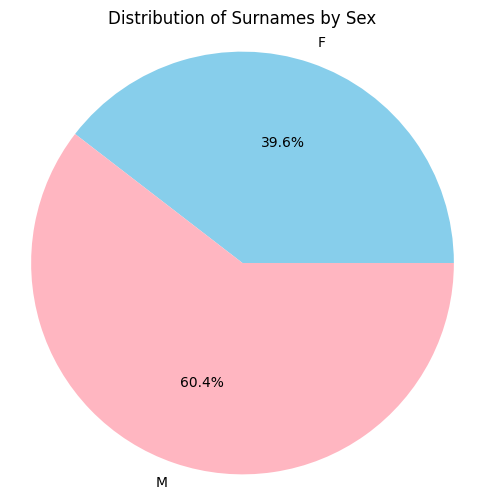

In [35]:
# Pie chart of surnames by sex
surnames_sex_count = surnames_by_sex.groupby('sex')['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(surnames_sex_count, labels=surnames_sex_count.index, autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
plt.title("Distribution of Surnames by Sex")
plt.axis('equal')
plt.show()


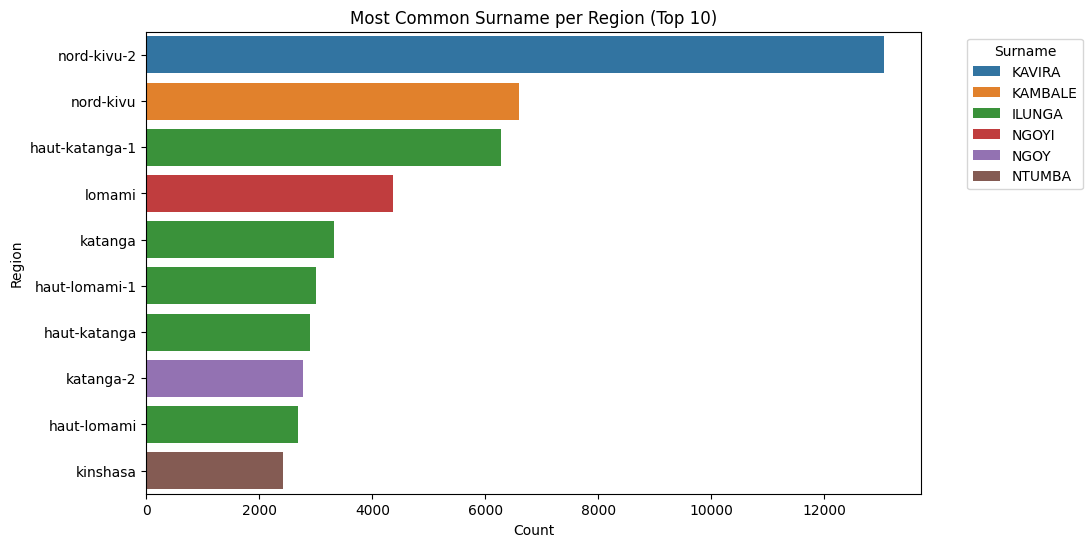

In [45]:
# Top 10 surnames per region (aggregated)
top_surnames_region = surnames_by_region.sort_values('count', ascending=False).drop_duplicates('region').head(10)
plt.figure(figsize=(10,6))
sns.barplot(y='region', x='count', data=top_surnames_region, hue='surname', dodge=False)
plt.title("Most Common Surname per Region (Top 10)")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Surname", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


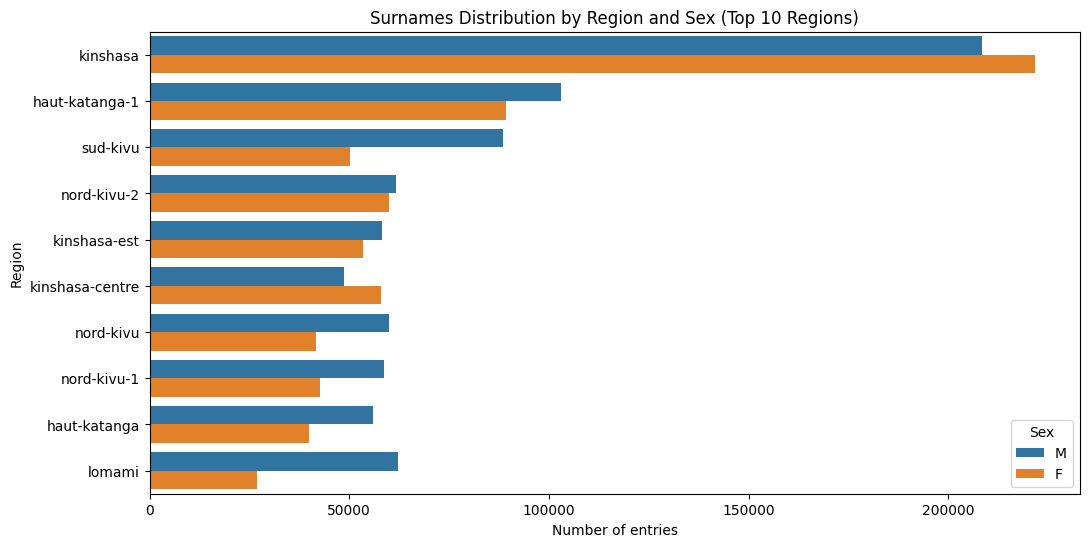

In [46]:
# Bar chart surnames by region and sex
top10_regions = df['region'].value_counts().head(10).index.tolist()
df_top10 = df[df['region'].isin(top10_regions)]
plt.figure(figsize=(12,6))
sns.countplot(data=df_top10, y='region', hue='sex', order=top10_regions)
plt.title("Surnames Distribution by Region and Sex (Top 10 Regions)")
plt.xlabel("Number of entries")
plt.ylabel("Region")
plt.legend(title='Sex')
plt.show()


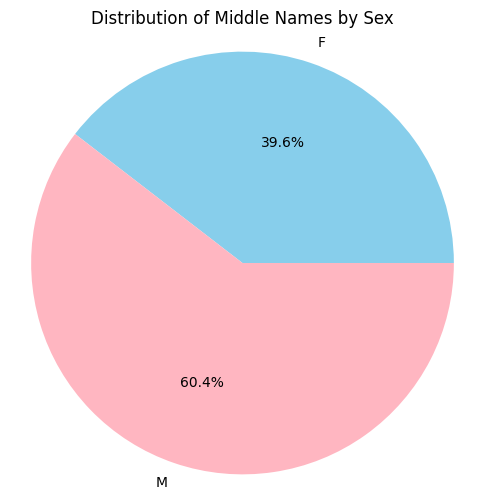

In [38]:
# Pie chart of middle names by sex
middlenames_sex_count = middlenames_by_sex.groupby('sex')['count'].sum()
plt.figure(figsize=(6,6))
plt.pie(middlenames_sex_count, labels=middlenames_sex_count.index, autopct='%1.1f%%', colors=['skyblue', 'lightpink'])
plt.title("Distribution of Middle Names by Sex")
plt.axis('equal')
plt.show()


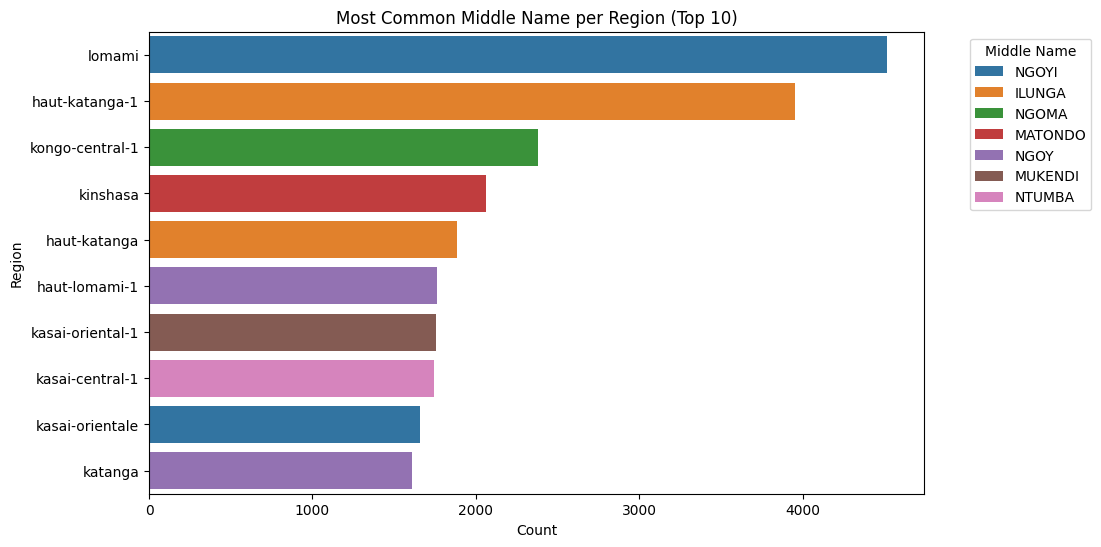

In [49]:
# Top 10 middle name per region
top_middlename_region = middlenames_by_region.sort_values('count', ascending=False).drop_duplicates('region').head(10)
plt.figure(figsize=(10,6))
sns.barplot(y='region', x='count', data=top_middlename_region, hue='middle_name', dodge=False)
plt.title("Most Common Middle Name per Region (Top 10)")
plt.xlabel("Count")
plt.ylabel("Region")
plt.legend(title="Middle Name", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
